In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [3]:
#Show columns
df.drop_duplicates(inplace=True)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


<Axes: xlabel='age', ylabel='diabetes'>

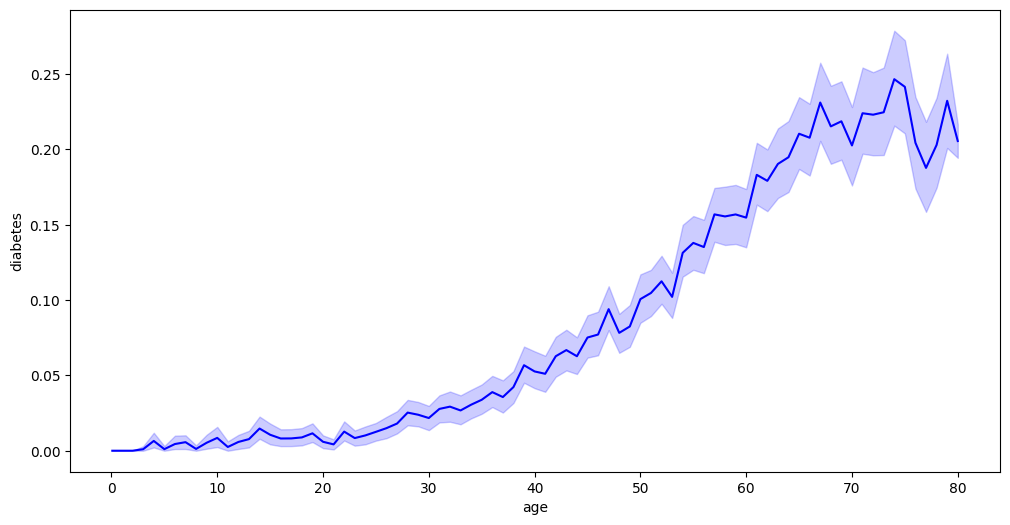

In [4]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df['age'],y=df['diabetes'],color='blue')

In [5]:
# One-hot encode categorical variables
data_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

# View the first few rows after encoding
data_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,True,False,True,False,False,False,False


In [6]:
# Separate features (X) and target (y)
X = data_encoded.drop('diabetes', axis=1)
y = data_encoded['diabetes']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
#Define entropy function
def entropy(feature):
    """
    This function calculates the entropy of a feature.

    Parameters:
    - feature (pandas.Series): The feature for which to calculate the entropy.

    Returns:
    - float: The entropy of the feature.
    """
    # Calculate the frequency of each unique value in the feature
    value_counts = feature.value_counts()
    # Calculate the probability of each unique value
    probabilities = value_counts / len(feature)
    # Calculate the entropy of the feature
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

#Define information gain function
def information_gain(data, feature_name, target_name):
    """
    This function calculates the information gain of a feature in a dataset.

    Parameters:
    - data (pandas.DataFrame): The dataset containing the feature and target.
    - split_name (str): The name of the feature for which to calculate information gain.
    - target_name (str): The name of the target feature.

    Returns:
    - float: The information gain of the feature.
    """
    # Calculate the entropy of the dataset
    target_entropy = entropy(data[target_name])

   # Caculate the entropy of the feature
    feature_entropy = 0
    feature = data[feature_name]
    for value in feature.unique():
        set = data[data[feature_name] == value]
        feature_entropy += len(set) / len(data) * entropy(set[target_name])
    # Calculate the information gain of the split feature
    information_gain = target_entropy - feature_entropy
    return information_gain

In [8]:
info_gains = {}
for feature in X.columns:
    info_gains[feature] = information_gain(data_encoded, feature, 'diabetes')

info_gains

{'age': 0.06168881131099829,
 'hypertension': 0.01937928387638843,
 'heart_disease': 0.0136968277236299,
 'bmi': 0.06743570095417761,
 'HbA1c_level': 0.19216320295374179,
 'blood_glucose_level': 0.16576557102363731,
 'gender_Male': 0.0010247467298919455,
 'gender_Other': 2.4947446097711712e-05,
 'smoking_history_current': 0.00020063064604780578,
 'smoking_history_ever': 0.00031750007781283784,
 'smoking_history_former': 0.005436800437752798,
 'smoking_history_never': 0.00038140654761553705,
 'smoking_history_not current': 0.00024344287583666357}

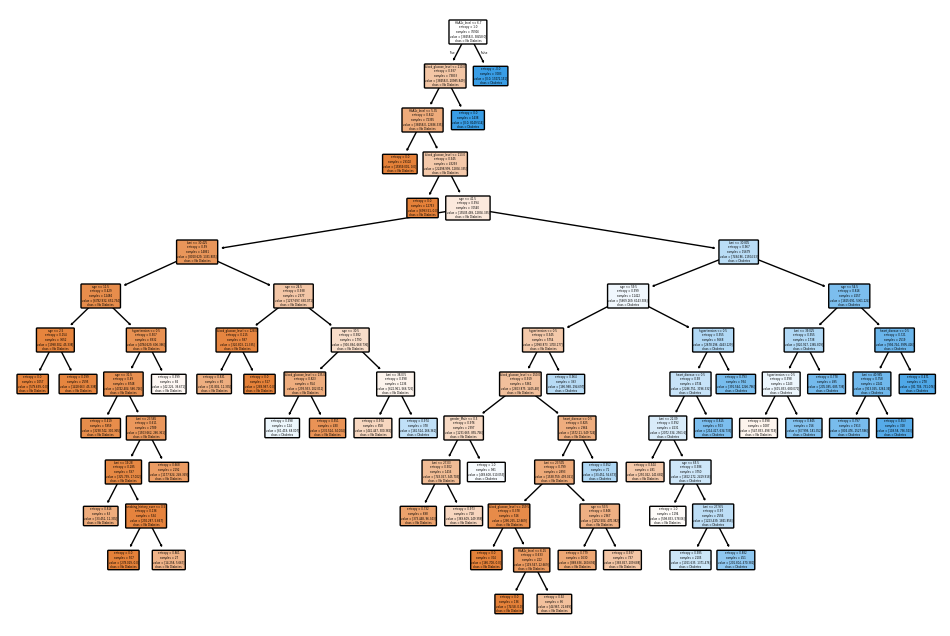

Decision Tree Accuracy: 0.8916276651066043

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     17534
           1       0.44      0.91      0.60      1696

    accuracy                           0.89     19230
   macro avg       0.72      0.90      0.77     19230
weighted avg       0.94      0.89      0.91     19230



In [9]:
# Instantiate the DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', random_state=42, max_leaf_nodes = 40,class_weight='balanced')

# Fit the decision tree model
dt.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt, filled=True, rounded=True, class_names=['No Diabetes', 'Diabetes'], feature_names=X.columns)
plt.show()

# Predict and evaluate
dt_pred = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, dt_pred))

In [10]:
# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Predict and evaluate
rf_pred = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.96931877275091

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.95      0.69      0.80      1696

    accuracy                           0.97     19230
   macro avg       0.96      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import issparse, csr_matrix

# Select features and target
X = df.drop("diabetes", axis=1)
y = df["diabetes"].values  # ensure numpy array for faster access

# Identify categorical and numerical columns
categorical_cols = ["gender", "smoking_history"]
numerical_cols = ["age", "bmi", "HbA1c_level", "blood_glucose_level", "hypertension", "heart_disease"]

# Create column transformer
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols)
])

# Transform features (returns sparse matrix)
X_processed = preprocessor.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Cast to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Compute class weights
class_counts = np.bincount(y_train)
total = len(y_train)
class_weights = {0: total / (2 * class_counts[0]), 1: total / (2 * class_counts[1])}

# Utility for sparse-safe matrix multiply
def sparse_dot(a, b):
    return a @ b if not issparse(a) else a.dot(b)

# Neural network implementation
class NN:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size).astype(np.float32) * 0.01
        self.b1 = np.zeros((1, hidden_size), dtype=np.float32)
        self.W2 = np.random.randn(hidden_size, output_size).astype(np.float32) * 0.01
        self.b2 = np.zeros((1, output_size), dtype=np.float32)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_deriv(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_deriv(self, z):
        return (z > 0).astype(np.float32)

    def forward(self, X):
        self.Z1 = sparse_dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1.dot(self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2

    def compute_loss(self, y_true, y_pred, weights):
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        sample_weights = np.vectorize(weights.get)(y_true.flatten())
        loss = -sample_weights * (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return np.mean(loss)

    def backward(self, X, y, output, weights, lr=0.01):
        m = y.shape[0]
        sample_weights = np.vectorize(weights.get)(y.flatten()).reshape(-1, 1).astype(np.float32)
        dZ2 = sample_weights * (output - y)
        dW2 = self.A1.T.dot(dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * self.relu_deriv(self.Z1)
        dW1 = sparse_dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def train(self, X, y, weights, epochs, lr, batch_size):
        y = y.reshape(-1, 1).astype(np.float32)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            for i in range(0, X.shape[0], batch_size):
                idx = indices[i:i+batch_size]
                X_batch = X[idx]
                y_batch = y[idx]
                out = self.forward(X_batch)
                self.backward(X_batch, y_batch, out, weights, lr)
            if epoch % 10 == 0:
                sample_idx = np.random.choice(X.shape[0], size=256, replace=False)
                loss = self.compute_loss(y[sample_idx], self.forward(X[sample_idx]), weights)
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        return (self.forward(X) > 0.5).astype(int).flatten()


In [13]:
# Train and evaluate
model = NN(input_size=X_train.shape[1], hidden_size=6, output_size=1)
model.train(X_train, y_train, class_weights, epochs=25, lr=0.01, batch_size=128)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Epoch 0, Loss: 0.6290
Epoch 10, Loss: 0.2452
Epoch 20, Loss: 0.2554
              precision    recall  f1-score   support

           0       0.99      0.89      0.93     17509
           1       0.43      0.89      0.58      1721

    accuracy                           0.89     19230
   macro avg       0.71      0.89      0.76     19230
weighted avg       0.94      0.89      0.90     19230



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f18e8e36-514b-4461-9b3c-37884e095599' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>